In [62]:
import nltk
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import json
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from collections import defaultdict
from string import punctuation
from heapq import nlargest

%matplotlib inline

In [2]:
comm_file_path = '../data/comm_use_subset/comm_use_subset'

In [8]:
dat = pd.read_csv("../data/all_sources_metadata_2020-03-13.csv")

In [57]:
with open(test_file) as json_data:
    tmp = json.load(json_data)
    metadata = tmp['metadata']
    paper_id = metadata['paper_id']
    title = metadata['title']
    body_text = tmp['body_text']
    full_text = ''
    for paragraph in body_text:
        full_text = full_text + paragraph['text'] + ' '

In [43]:
test_file = '../data/comm_use_subset/comm_use_subset/5e0c586f047ff909c8ed3fe171c8975a90608d08.json'

In [3]:
def getText():
    text_list = []
    for root,dirs,files in os.walk(comm_file_path):
        for i, file in enumerate(files):
            with open(root+'/'+file) as json_data:
                tmp = json.load(json_data)
                metadata = tmp['metadata']
                title = metadata['title']
                body_text = tmp['body_text']
                full_text = ''
                for paragraph in body_text:
                    full_text = full_text + paragraph['text'] + ' '
                text_list.append(full_text)
    return text_list

In [4]:
text_list = getText()

In [5]:
len(text_list)

9001

In [10]:
text_list[90][:10]

'Immunother'

In [11]:
vectorizer = TfidfVectorizer(max_df=0.9, min_df=0.2,stop_words='english')

In [12]:
X = vectorizer.fit_transform(text_list)

In [13]:
X

<9001x1016 sparse matrix of type '<class 'numpy.float64'>'
	with 3369639 stored elements in Compressed Sparse Row format>

In [18]:
kn = KMeans(n_clusters=10, max_iter = 100, verbose=True)

In [19]:
kn.fit(X)

Initialization complete
Iteration  0, inertia 10939.690
Iteration  1, inertia 6369.187
Iteration  2, inertia 6281.000
Iteration  3, inertia 6249.312
Iteration  4, inertia 6224.145
Iteration  5, inertia 6186.572
Iteration  6, inertia 6148.835
Iteration  7, inertia 6135.666
Iteration  8, inertia 6132.845
Iteration  9, inertia 6130.434
Iteration 10, inertia 6128.321
Iteration 11, inertia 6126.398
Iteration 12, inertia 6124.667
Iteration 13, inertia 6123.018
Iteration 14, inertia 6121.617
Iteration 15, inertia 6120.345
Iteration 16, inertia 6119.111
Iteration 17, inertia 6118.229
Iteration 18, inertia 6117.533
Iteration 19, inertia 6116.813
Iteration 20, inertia 6116.072
Iteration 21, inertia 6115.305
Iteration 22, inertia 6114.550
Iteration 23, inertia 6113.783
Iteration 24, inertia 6113.277
Iteration 25, inertia 6112.890
Iteration 26, inertia 6112.679
Iteration 27, inertia 6112.508
Iteration 28, inertia 6112.444
Iteration 29, inertia 6112.416
Iteration 30, inertia 6112.392
Iteration 31, 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=True)

In [24]:
np.unique(kn.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([1060,  633,  521, 1292,  511,  532, 1391, 1233,  578, 1250]))

In [26]:
pd.DataFrame(kn.labels_).to_csv('kn_labels_10.csv')

In [29]:
text = {}
for i, cluster in enumerate(kn.labels_):
    oneDocument = text_list[i]
    if cluster not in text.keys():
        text[cluster] = oneDocument
    else:
        text[cluster] += oneDocument

In [39]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /Users/mho/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mho/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [32]:
_stopwords = set(stopwords.words('english') + list(punctuation))

In [46]:
keywords = {}
counts = {}
for cluster in range(10):
    word_sent = word_tokenize(text[cluster].lower())
    word_sent = [word for word in word_sent if word not in _stopwords]
    freq = FreqDist(word_sent)
    keywords[cluster] = nlargest(50, freq, key=freq.get)
    counts[cluster] = freq

In [27]:
kn.labels_.shape

(9001,)

In [180]:
unique_keys={}
for cluster in range(10):
    other_clusters = list(set(range(10))-set([cluster]))
    keys_other_clusters = set(keywords[other_clusters[0]]).union(set(keywords[other_clusters[1]]))
    unique = set(keywords[cluster]) - keys_other_clusters
    unique_keys[cluster] = nlargest(3, unique, key=counts[cluster].get)

In [181]:
unique_keys

{0: ['proteins', 'rna', 'binding'],
 1: ['influenza', 'respiratory', 'children'],
 2: ['mice', 'infected', 'immune'],
 3: ['model', 'number', 'transmission'],
 4: ['et', 'al.', 'al'],
 5: ['public', 'diseases', '``'],
 6: ['infected', 'h', 'control'],
 7: ['vaccine', 'immune', 'antibody'],
 8: ['patient', 'treatment', 'hospital'],
 9: ['sequences', 'gene', 'genome']}

In [182]:
svd = TruncatedSVD(n_components=2, n_iter=5, random_state=42)

In [183]:
svd.fit(X)

TruncatedSVD(algorithm='randomized', n_components=2, n_iter=5, random_state=42,
             tol=0.0)

In [184]:
compressed = svd.transform(X)

In [185]:
x, y = compressed[0]

In [186]:
cluster_coords = {}
for i, cluster in enumerate(kn.labels_):
    x,y = compressed[i]
    if cluster not in cluster_coords.keys():
        cluster_coords[cluster] = [[x,y]]
    else:
        cluster_coords[cluster] = np.append(cluster_coords[cluster],[[x,y]],axis=0)
cluster_centroids = {}
for cluster in cluster_coords.keys():
    cluster_centroids[cluster] = cluster_coords[cluster].mean(axis=0)

In [187]:
cluster_centroids

{6: array([0.56133279, 0.28392894]),
 7: array([0.43852969, 0.00753708]),
 4: array([ 0.41601356, -0.0477402 ]),
 8: array([ 0.38362163, -0.27849632]),
 0: array([0.4500647 , 0.12143448]),
 9: array([ 0.40690893, -0.10584287]),
 2: array([0.49967426, 0.19217508]),
 3: array([ 0.30242555, -0.23839691]),
 5: array([ 0.26767655, -0.30599867]),
 1: array([ 0.39064156, -0.31941834])}

In [188]:
for i, text in enumerate(unique_keys.values()):
    print('-'.join(text))

proteins-rna-binding
influenza-respiratory-children
mice-infected-immune
model-number-transmission
et-al.-al
public-diseases-``
infected-h-control
vaccine-immune-antibody
patient-treatment-hospital
sequences-gene-genome


Text(0.5, 1.0, 'Covid-19 articles in 10 clusters by KMeans and represented in 2D Space by Truncated SVD')

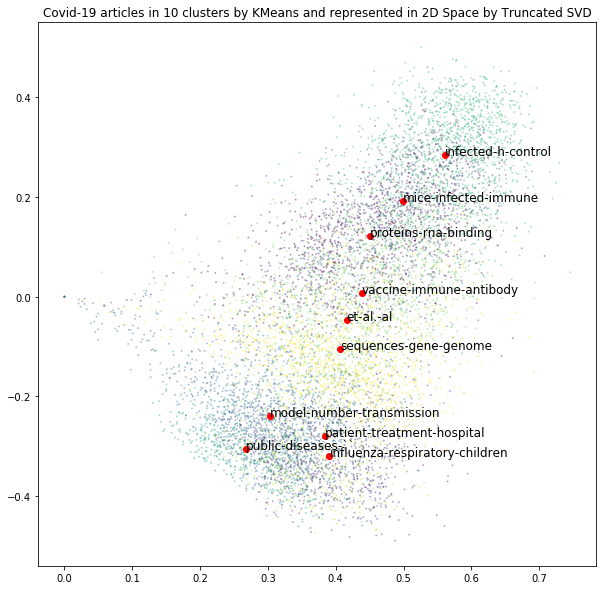

In [195]:
plt.figure(figsize=(10,10))
plt.scatter(compressed.T[0],compressed.T[1], c=kn.labels_, s=1, alpha=.3)
for cluster in cluster_centroids.keys():
    plt.scatter(cluster_centroids[cluster][0],cluster_centroids[cluster][1], c='red', linewidths=1)
for i, text in enumerate(unique_keys.values()):
    txt = '-'.join(text)
    plt.annotate(txt, (cluster_centroids[i][0], cluster_centroids[i][1]),size=12)
plt.title('Covid-19 articles in 10 clusters by KMeans and represented in 2D Space by Truncated SVD')